# awkward 配列の内部構造

awkward 配列は複数の一次元配列を組み合わせて階層的な構造を構成します。本章では、`layout` 属性を確認しながら、awkward 配列がどのように内部表現されるかを説明します。
本文中の `%t` マジックコマンドは、配列の値・`layout`・そしてカスタム `dot()` 関数で可視化したグラフを一度に表示するために用います。

In [1]:
from IPython.display import display
import numpy as np
import awkward as ak
from IPython.core.magic import register_line_magic
import html
from helper.awkward import dot

以下は、awkward 配列の値、内部レイアウト (`layout`)、および構造のグラフをまとめて可視化するためのマジックコマンドです。

In [2]:
@register_line_magic
def t(line):
    ip = get_ipython()
    ip.ex(line)
    name = line.split("=")[0].strip()
    arr = ip.user_global_ns[name]
    html_str = html.unescape(arr._repr_mimebundle_()['text/html'])
    html_str = html_str.replace("</pre>", "").replace("<pre>", "")
    html_str = f"{html_str}\n\n{arr._layout}"
    g = dot(arr)
    display(g)
    print(html_str)

## NumpyArray

`np.arange(12)` を awkward 配列に変換した例です。
表示された内部構造は **単一の `NumpyArray` ノード**で、値は 0～11 の連続整数でした。

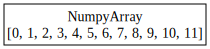

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11]
----
backend: cpu
nbytes: 96 B
type: 12 * int64

<NumpyArray dtype='int64' len='12'>
    [ 0  1  2  3  4  5  6  7  8  9 10 11]
</NumpyArray>


In [3]:
%t a1 = ak.Array(np.arange(12))

## ByteMaskedArray

`a1 % 2 == 0` を条件にマスクすると、奇数位置が `None` になった配列になります。
内部表現は **ByteMaskedArray（mask + content）** となり、`mask` は `int8` の 1/0 配列です。

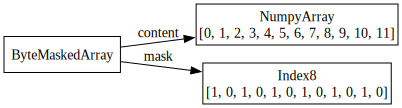

[0,
 None,
 2,
 None,
 4,
 None,
 6,
 None,
 8,
 None,
 10,
 None]
------
backend: cpu
nbytes: 108 B
type: 12 * ?int64

<ByteMaskedArray valid_when='true' len='12'>
    <mask><Index dtype='int8' len='12'>[1 0 1 0 1 0 1 0 1 0 1 0]</Index></mask>
    <content><NumpyArray dtype='int64' len='12'>
        [ 0  1  2  3  4  5  6  7  8  9 10 11]
    </NumpyArray></content>
</ByteMaskedArray>


In [4]:
%t a2 = ak.mask(a1, a1 % 2 == 0)

## IndexedOptionArray

Python リスト由来で `None` を含む配列を作ると、awkward は
**IndexedOptionArray（index + content）** で表現します。
負の index が `None` を表す点が特徴です。

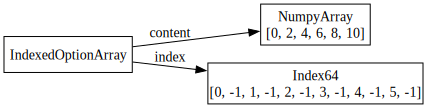

[0,
 None,
 2,
 None,
 4,
 None,
 6,
 None,
 8,
 None,
 10,
 None]
------
backend: cpu
nbytes: 144 B
type: 12 * ?int64

<IndexedOptionArray len='12'>
    <index><Index dtype='int64' len='12'>
        [ 0 -1  1 -1  2 -1  3 -1  4 -1  5 -1]
    </Index></index>
    <content><NumpyArray dtype='int64' len='6'>[ 0  2  4  6  8 10]</NumpyArray></content>
</IndexedOptionArray>


In [5]:
%t a2 = ak.Array([0, None, 2, None, 4, None, 6, None, 8, None, 10, None])

## ListOffsetArray

`unflatten` を用いて `[1,2,3,4,2]` の長さに分割すると、
内部構造は **ListOffsetArray（offsets + content）** となります。
`offsets` は累積和であり、配列の切れ目を表します。

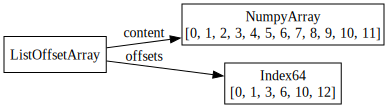

[[0],
 [1, 2],
 [3, 4, 5],
 [6, 7, 8, 9],
 [10, 11]]
--------------
backend: cpu
nbytes: 144 B
type: 5 * var * int64

<ListOffsetArray len='5'>
    <offsets><Index dtype='int64' len='6'>[ 0  1  3  6 10 12]</Index></offsets>
    <content><NumpyArray dtype='int64' len='12'>
        [ 0  1  2  3  4  5  6  7  8  9 10 11]
    </NumpyArray></content>
</ListOffsetArray>


In [6]:
%t a2 = ak.unflatten(a1, [1, 2, 3, 4, 2])

## ListArray

`a2[[3,4,1]]` のようにリストでインデックス指定すると、
awkward は **ListArray（starts + stops + content）** を構築します。
`starts` と `stops` によってスライス対象が決まります。

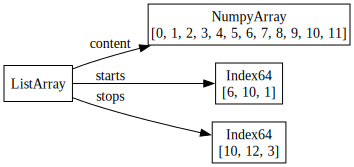

[[6, 7, 8, 9],
 [10, 11],
 [1, 2]]
--------------
backend: cpu
nbytes: 144 B
type: 3 * var * int64

<ListArray len='3'>
    <starts><Index dtype='int64' len='3'>
        [ 6 10  1]
    </Index></starts>
    <stops><Index dtype='int64' len='3'>
        [10 12  3]
    </Index></stops>
    <content><NumpyArray dtype='int64' len='12'>
        [ 0  1  2  3  4  5  6  7  8  9 10 11]
    </NumpyArray></content>
</ListArray>


In [7]:
%t a3 = a2[[3, 4, 1]]

## RecordArray

`ak.zip` を使って `{x: a2, y: a2+10}` を作ると、
各要素がフィールド `x` と `y` を持つ **RecordArray** になり、
外側は元の `a2` の構造を引き継いだ ListOffsetArray です。

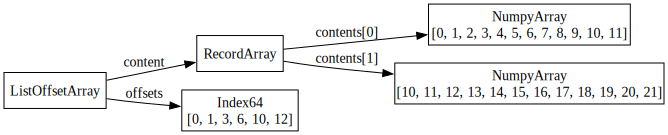

[[{x: 0, y: 10}],
 [{x: 1, y: 11}, {x: 2, y: 12}],
 [{x: 3, y: 13}, {x: 4, y: 14}, {x: 5, y: 15}],
 [{x: 6, y: 16}, {x: 7, y: 17}, {x: 8, y: 18}, {x: 9, y: 19}],
 [{x: 10, y: 20}, {x: 11, y: 21}]]
--------------------------------------------------------------
backend: cpu
nbytes: 240 B
type: 5 * var * {
    x: int64,
    y: int64
}

<ListOffsetArray len='5'>
    <offsets><Index dtype='int64' len='6'>
        [ 0  1  3  6 10 12]
    </Index></offsets>
    <content><RecordArray is_tuple='false' len='12'>
        <content index='0' field='x'>
            <NumpyArray dtype='int64' len='12'>
                [ 0  1  2  3  4  5  6  7  8  9 10 11]
            </NumpyArray>
        </content>
        <content index='1' field='y'>
            <NumpyArray dtype='int64' len='12'>
                [10 11 12 13 14 15 16 17 18 19 20 21]
            </NumpyArray>
        </content>
    </RecordArray></content>
</ListOffsetArray>


In [8]:
%t a4 = ak.zip({'x': a2, 'y': a2 + 10})

## IndexedArray

`a4['x'] > 4.0` を条件にフィルタすると、
内部的には **IndexedArray（index + content）** によって必要なレコードのみ参照する構造になります。
外側は引き続き ListOffsetArray です。

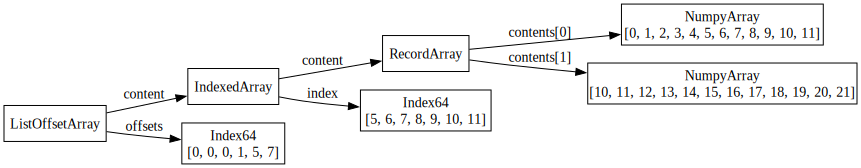

[[],
 [],
 [{x: 5, y: 15}],
 [{x: 6, y: 16}, {x: 7, y: 17}, {x: 8, y: 18}, {x: 9, y: 19}],
 [{x: 10, y: 20}, {x: 11, y: 21}]]
--------------------------------------------------------------
backend: cpu
nbytes: 296 B
type: 5 * var * {
    x: int64,
    y: int64
}

<ListOffsetArray len='5'>
    <offsets><Index dtype='int64' len='6'>[0 0 0 1 5 7]</Index></offsets>
    <content><IndexedArray len='7'>
        <index><Index dtype='int64' len='7'>
            [ 5  6  7  8  9 10 11]
        </Index></index>
        <content><RecordArray is_tuple='false' len='12'>
            <content index='0' field='x'>
                <NumpyArray dtype='int64' len='12'>
                    [ 0  1  2  3  4  5  6  7  8  9 10 11]
                </NumpyArray>
            </content>
            <content index='1' field='y'>
                <NumpyArray dtype='int64' len='12'>
                    [10 11 12 13 14 15 16 17 18 19 20 21]
                </NumpyArray>
            </content>
        </RecordArray></cont

In [9]:
%t a5 = a4[a4['x'] > 4.0]

## option + list の重層構造

`a2.mask[...]` を二段階で適用すると、
外側が IndexedOptionArray、
内側が ListOffsetArray、
さらにその content が ByteMaskedArray という多層構造になります。

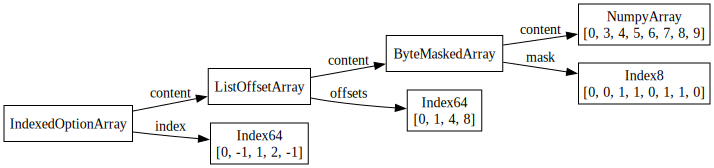

[[None],
 None,
 [None, 4, 5],
 [None, 7, 8, None],
 None]
--------------------
backend: cpu
nbytes: 144 B
type: 5 * option[var * ?int64]

<IndexedOptionArray len='5'>
    <index><Index dtype='int64' len='5'>[ 0 -1  1  2 -1]</Index></index>
    <content><ListOffsetArray len='3'>
        <offsets><Index dtype='int64' len='4'>[0 1 4 8]</Index></offsets>
        <content><ByteMaskedArray valid_when='true' len='8'>
            <mask><Index dtype='int8' len='8'>
                [0 0 1 1 0 1 1 0]
            </Index></mask>
            <content><NumpyArray dtype='int64' len='8'>[0 3 4 5 6 7 8 9]</NumpyArray></content>
        </ByteMaskedArray></content>
    </ListOffsetArray></content>
</IndexedOptionArray>


In [11]:
a7 = a2.mask[ak.num(a2) != 2]
%t a7 = a7.mask[a7 % 3 != 0]

## string 配列

awkward の string は
**ListOffsetArray（各文字列の offsets） + char の NumpyArray**
として保存されます。

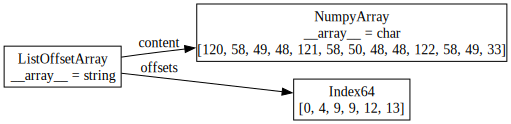

['x:10',
 'y:200',
 '',
 'z:1',
 '!']
---------
backend: cpu
nbytes: 61 B
type: 5 * string

<ListOffsetArray len='5'>
    <parameter name='__array__'>'string'</parameter>
    <offsets><Index dtype='int64' len='6'>[ 0  4  9  9 12 13]</Index></offsets>
    <content><NumpyArray dtype='uint8' len='13'>
        <parameter name='__array__'>'char'</parameter>
        [120  58  49  48 121  58  50  48  48 122  58  49  33]
    </NumpyArray></content>
</ListOffsetArray>


In [12]:
%t a8 = ak.Array(["x:10", "y:200", "", "z:1", "!"])

## 文字列配列のインデックス参照

`a8[[2,1,0,-1]]` のように順序を入れ替えると、
string 配列にも **ListArray（starts + stops + content）** が用いられます。

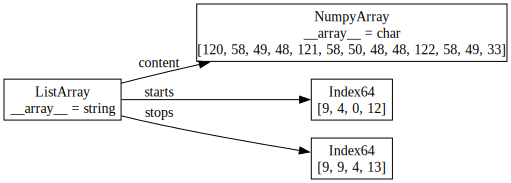

['',
 'y:200',
 'x:10',
 '!']
---------
backend: cpu
nbytes: 77 B
type: 4 * string

<ListArray len='4'>
    <parameter name='__array__'>'string'</parameter>
    <starts><Index dtype='int64' len='4'>
        [ 9  4  0 12]
    </Index></starts>
    <stops><Index dtype='int64' len='4'>
        [ 9  9  4 13]
    </Index></stops>
    <content><NumpyArray dtype='uint8' len='13'>
        <parameter name='__array__'>'char'</parameter>
        [120  58  49  48 121  58  50  48  48 122  58  49  33]
    </NumpyArray></content>
</ListArray>


In [13]:
%t a9 = a8[[2, 1, 0, -1]]

## 文字列の2次元配列

`ak.str.split_pattern(a8, ':')` は
文字列のリストを返し、
**二重の ListOffsetArray**（外側＝入力文字列、内側＝分割結果）
によって表現されます。

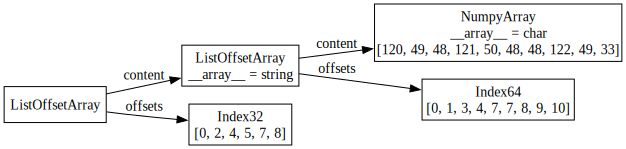

[['x', '10'],
 ['y', '200'],
 [''],
 ['z', '1'],
 ['!']]
--------------
backend: cpu
nbytes: 106 B
type: 5 * var * string

<ListOffsetArray len='5'>
    <offsets><Index dtype='int32' len='6'>[0 2 4 5 7 8]</Index></offsets>
    <content><ListOffsetArray len='8'>
        <parameter name='__array__'>'string'</parameter>
        <offsets><Index dtype='int64' len='9'>
            [ 0  1  3  4  7  7  8  9 10]
        </Index></offsets>
        <content><NumpyArray dtype='uint8' len='10'>
            <parameter name='__array__'>'char'</parameter>
            [120  49  48 121  50  48  48 122  49  33]
        </NumpyArray></content>
    </ListOffsetArray></content>
</ListOffsetArray>


In [14]:
%t a10 = ak.str.split_pattern(a8, ':')

## UnionArray

`ak.where(cond, a1, strings)` のように型が混ざる場合、
awkward は **UnionArray（tags + index + content[s]）** を用います。
整数と文字列という異なる型が共存する典型例です。

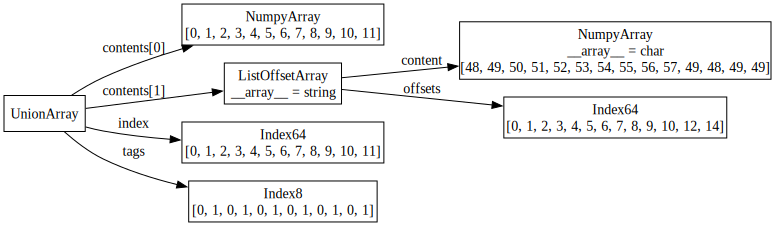

[0,
 '1',
 2,
 '3',
 4,
 '5',
 6,
 '7',
 8,
 '9',
 10,
 '11']
------
backend: cpu
nbytes: 322 B
type: 12 * union[
    int64,
    string
]

<UnionArray len='12'>
    <tags><Index dtype='int8' len='12'>[0 1 0 1 0 1 0 1 0 1 0 1]</Index></tags>
    <index><Index dtype='int64' len='12'>
        [ 0  1  2  3  4  5  6  7  8  9 10 11]
    </Index></index>
    <content index='0'>
        <NumpyArray dtype='int64' len='12'>
            [ 0  1  2  3  4  5  6  7  8  9 10 11]
        </NumpyArray>
    </content>
    <content index='1'>
        <ListOffsetArray len='12'>
            <parameter name='__array__'>'string'</parameter>
            <offsets><Index dtype='int64' len='13'>
                [ 0  1  2  3  4  5  6  7  8  9 10 12 14]
            </Index></offsets>
            <content><NumpyArray dtype='uint8' len='14'>
                <parameter name='__array__'>'char'</parameter>
                [48 49 50 51 52 53 54 55 56 57 49 48 49 49]
            </NumpyArray></content>
        </ListOffse

In [15]:
%t a11 = ak.where(a1 % 2 == 0, a1, [str(v) for v in a1])